# 2024 COMP90042 Project (W9AM Group 5)
### Authors: 
- Flynn Schneider (982143)
- Abbey He (949219)
- Jonathan Lätti (108337)
- Zihang Xu (1446938)

# Readme

**RUN NOTES**

Run all cells in order listed. Expect extended training duration (> 30 mins on CPU) for Language Model training (2.1). Save model weights and parameters for models and/or use previously training model parameters to save total runtime on successive runs.

# 1.DataSet Processing


## 1.0 Import Statements

In [46]:
import json
import re
import random
import numpy as np
import torch
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt
from heapq import nlargest
from annoy import AnnoyIndex
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    RepeatVector,
    TimeDistributed,
    Masking,
    Dropout,
    Bidirectional,
    Input,
    Lambda,
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from gensim.models import Word2Vec, KeyedVectors

## 1.1 Preprocessing

Download the evidence and train-claims json files as dict objects.
**NOTE**: The commented out code is to be run only if files are stored in a base folder within a google drive called *Data* and that the drive is accessible. (Change paths if necessary).  

In [3]:

with open("Data/dev-claims.json", "r") as f:
    dev_claims = json.load(f)

with open("Data/test-claims-unlabelled.json", "r") as f:
    test_claims_unlabelled = json.load(f)

with open("Data/train-claims.json", "r") as f:
    train_claims = json.load(f)

with open("Data/evidence.json", "r") as f:
    evidence = json.load(f)


print("# of items in each dataset loaded:")
print("Evidences:", len(list(evidence)))
print("Train:", len(list(train_claims.keys())))
print("Dev:", len(list(dev_claims.keys())))
print("Test:", len(list(test_claims_unlabelled.keys())))

# of items in each dataset loaded:
Evidences: 1208827
Train: 1228
Dev: 154
Test: 153


**Combine all Training Claims and Evidence texts into one set**

- *evidence_texts* = All evidence
- *claims_texts* = All training claims
- *all_sentences* = All evidence + claims texts



In [4]:
evidence_texts = [evidence[key] for key in list(evidence)]
evidence_keys = list(evidence)
claim_texts = [train_claims[key]['claim_text'] for key in list(train_claims)]

evidence_and_claims = evidence_texts + claim_texts
print("Total sentences:", len(evidence_and_claims))

Total sentences: 1210055


**Preprocess and tokenize sentences**
- Lowercase
- Split on whitespace
- Tokenize with "basic_english" prebuilt tokenizer
- Remove empty tokens

In [5]:
def pre_process(sentence):
    return sentence.lower()

def tokenize(sentence):
    tokenizer = get_tokenizer("basic_english")
    return [token for token in tokenizer(sentence) if re.match(r'^[a-zA-Z0-9]+$', token)]

sentences_preprocessed = [pre_process(sentence) for sentence in evidence_and_claims] # "pre-process" all sentences

sentences_tokenised_all = [tokenize(sentence) for sentence in sentences_preprocessed] # tokenise all sentences
sentences_tokenised = [tokens for tokens in sentences_tokenised_all if len(tokens) > 1] # remove sentences with only one token

## 1.2 Word Embeddings Model (Word2Vec)

**Create word embeddings using pre-trained Word2Vec model (from Gensim package)**
- Represent's word as feature vector of length 100

In [6]:
# hyper_params
vector_size = 100
window = 5
min_count = 1
workers = 4

sentences = sentences_tokenised
w2v_model = Word2Vec(
    sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers
)

**Example retrieval of similar words using word embeddings model and a token key_word**

In [7]:
key_word = 'climate'
similar_words = w2v_model.wv.most_similar(key_word)

word_vector = w2v_model.wv[key_word]

print("Vocabulary size:", len(w2v_model.wv))
print("Words similar to '" + key_word + "':", similar_words)
print("Word vector length:", len(word_vector))

Vocabulary size: 512440
Words similar to 'climate': [('global', 0.7491486072540283), ('environmental', 0.746711790561676), ('warming', 0.7383171916007996), ('climatic', 0.7068337202072144), ('mitigation', 0.6873947978019714), ('anthropogenic', 0.6720764636993408), ('resilience', 0.6684873700141907), ('impacts', 0.660208523273468), ('biodiversity', 0.642614483833313), ('vulnerability', 0.6418792009353638)]
Word vector length: 100


## 1.3: Mean Sentence Embeddings and Matrix Sentence Embeddings Functions

**Token embeddings and sentence word embeddings helper functions:**
- **`token_to_embedding(token)`**
 - returns word embeddings vector of size 100
- **`sentence_to_word_embeddings(token)`**
 - returns 2D word embeddings vector of size (*# of sentence tokens*,   100)




In [8]:

def token_to_embedding(token):
    try:
        return w2v_model.wv[token]
    except:
        return np.random.rand(vector_size)

def sentence_to_word_embeddings(tokenised_sentence):
    return [token_to_embedding(token) for token in tokenised_sentence]

**Evidence filtering helper function:**
- **`mean_sentence_embedding(vectors)`**
 - returns a single sentence embeddings vector of size 100 based on the average of that sentences individual token word embeddings vectors
- **`get_mean_sentence_embedding(vectors)`**
 - Does the same but for numerous sentences
 - `Dimensions` is an optional parameter that allows for naively lower dimensional mean embeddings to be retrieved. Defaults to 100.
 - returns matrix of mean sentence embeddings of size (*# of sentences*,   dimensions)

In [9]:
def mean_sentence_embedding(vectors):
    return np.mean(vectors, axis=0)

def get_mean_sentence_embeddings(sentences, dimensions = 100):
    embeddings = []

    # Tokenise sentences
    tokenised_sentences = [tokenize(sentence) for sentence in sentences]

    # Word2vec words in sentences
    vectors = sentence_to_word_embeddings(tokenised_sentences)

    for sentence in vectors:
        # Assuming encoder_model is a function that returns sentence embeddings
        embedding = mean_sentence_embedding(sentence)
        if dimensions and type(embedding) == np.ndarray:

            embedding = embedding[:dimensions]

            embeddings.append(embedding)
        else:
            # default embedding to zeros vector of
            embeddings.append(np.zeros(dimensions))
    return np.array(embeddings)

Sets up the feature-label representations of evidence set required for the training of a supervised filter classifier
- **Features:** Mean Sentence Embeddings for a sentence
- **Labels:** `1` if a claim-evidence linked evidence sentence, else `0`

In [10]:
claim_evidence_lists = []
for key, value in train_claims.items():
    claim_evidence_lists.append(value["evidences"])

# flatten the list
claim_evidences = [item for sublist in claim_evidence_lists for item in sublist]
claim_evidences_set = list(set(claim_evidences))

# Get the evidence texts
claim_evidence_texts = [evidence[key] for key in claim_evidences_set]

# Get evidence up to index len-X
X = -1
random_evidence_texts = evidence_texts

# filter out claim evidence texts
random_evidence_texts = [text for text in random_evidence_texts if text not in claim_evidence_texts]

# Get the mean sentence embeddings for the first 10000 evidence texts, 2000 at a time
random_evidence_embeddings = []
for i in range(0, len(random_evidence_texts), 10000):
    print(f"Progress: {i}/{len(random_evidence_texts)}", end="\r")
    random_evidence_embeddings.extend(
        get_mean_sentence_embeddings(random_evidence_texts[i : i + 10000])
    )
claim_evidence_embeddings = get_mean_sentence_embeddings(claim_evidence_texts)

# Make a labels vector
labels = np.array([1] * len(claim_evidence_embeddings) + [0] * len(random_evidence_embeddings))

# Concatenate the embeddings
features = np.concatenate((claim_evidence_embeddings, random_evidence_embeddings), axis=0)

Input class weights for `0`, `1` classes (according to the true proportions) to bias classifier back towards the minority class (ie: `1` / linked-evidence)

In [11]:
# Calculate class weights
true_evidence_ratio = len(claim_evidence_texts) / len(evidence_texts)  # ratio of linked-evidence to total evidence size
class_weight_0 = 1
class_weight_1 = 1 / true_evidence_ratio

# Create dictionary with class weights
class_weights = {0: class_weight_0, 1: class_weight_1}

Train a high recall (for class 1) Logistic Regression classifier to filter out the most likely *unrelated* evidence sentences.

In [12]:
# Make a supervised linear classifier with features and labels

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)

clf = LogisticRegression(class_weight=class_weights, random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F-score:", f_score)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.919947221584552
F-score: 0.05470352642375696
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    482290
           1       0.03      0.90      0.05      1241

    accuracy                           0.92    483531
   macro avg       0.51      0.91      0.51    483531
weighted avg       1.00      0.92      0.96    483531



Filter evidence based on the classifier's confidence of class membership (relevancy). Use only `filtered_evidence_texts` for downstream evidence retrieval tasks.



In [13]:
decision_boundary = 0.5 # Default LR decision boundary

filtered_evidence_texts = []
filtered_evidence_embeddings = []
filtered_evidence_labels = []
filtered_evidence_keys = []

for i, text in enumerate(evidence_texts):

    progress = (i + 1) / len(evidence_texts) * 100
    print(f"Progress: {progress:.2f}% ({i + 1}/{len(evidence_texts)})", end="\r")

    embedding = get_mean_sentence_embeddings([text])
    label = clf.predict(embedding)[0]
    proba = clf.predict_proba(embedding)[0][1]
    key = evidence_keys[i]

    if label == 1 and proba > decision_boundary:
        filtered_evidence_texts.append(text)
        filtered_evidence_embeddings.append(embedding)
        filtered_evidence_labels.append(label)
        filtered_evidence_keys.append(key)

# Manually add evidence linked to train claims back
for key in train_claims:
    claim_object = train_claims[key]
    evidences = claim_object["evidences"]

    for entry in evidences:
        if entry not in filtered_evidence_keys:
            filtered_evidence_keys.append(entry)
            filtered_evidence_texts.append(evidence[entry])

print("Prefiltering evidence texts:", len(evidence_texts))
print("Filtered evidence texts:", len(filtered_evidence_texts))

Prefiltering evidence texts: 1208827
Filtered evidence texts: 99611


## 1.5: Pre language model preparation

Indexes tokens with unique token ids (and special token ids)

In [14]:
word_embeddings_vocab = w2v_model.wv.key_to_index
word_embeddings = {word: w2v_model.wv[word] for word in word_embeddings_vocab}

pad_token = 0
predict_token = 1
unknown_token = 2

total_specials = 3 # pad, predict, unknown

word_index = {word: (idx+total_specials) for idx, word in enumerate(word_embeddings_vocab)}

Helper functions for:
- Extracting token indexes (`get_index(word)`) and...
- Turning a tokenised sentence into a (all previous words ids, last id) tuple (`sentence_to_ids_hidden_final(tokenised_sentence)`)

In [15]:
def get_index(word):
    if word in word_index:
        return word_index[word]
    else:
        return unknown_token

def sentence_to_ids_hidden_final(tokenised_sentence):

    sentence_ids = []
    for word in tokenised_sentence[:-1]:
        sentence_ids.append(get_index(word))

    sentence_ids.append(predict_token)

    final_word = tokenised_sentence[-1]
    last_word_idx = get_index(final_word)

    return (sentence_ids, last_word_idx)

**More sentence transformations...**
- Create `word_embeddings` dict (word to word embeddings vector), `word_index` dict (word to index), `index_to_embedding` dict (index to embedding), `sentences_as_ids` list (list of indexed sentences instead of tokens)



- `padded_sentences_as_ids` transforms all indexed sentences to be of maximum length 25 with *zeroes* filling out sentences of shorter length at the end (`'post'`)





In [16]:
sentence_tuples = [sentence_to_ids_hidden_final(sentence) for sentence in sentences_tokenised if sentence != None]

sentences_as_ids = [sentence[0] for sentence in sentence_tuples]
sentences_as_ids_labels = [sentence[1] for sentence in sentence_tuples]

In [17]:
# Maximum length of a sentence. All sentences longer than this will be truncated to this length. All sentences shorter than this will be padded to this length.
max_len = 50    

padded_sentences_as_ids = pad_sequences(
    sentences_as_ids,
    padding='post',
    dtype='float32',
    maxlen=max_len,
    value=pad_token
)

index_to_embedding = {idx: word_embeddings[word] for word, idx in word_index.items()}

In [19]:
def get_embedding_from_index(idx):
    if idx != pad_token and idx != predict_token:
        return index_to_embedding[idx]
    else:
        return np.zeros(vector_size)

for test_idx in [10, 0, 1]:
    embedding = get_embedding_from_index(test_idx)

# 2. Model Implementation


## 2.0: Experimental Models: AUTOENCODER (disabled)

In [28]:
# # Autoencoder

# word_embedding_size = vector_size
# sentence_length = max_len

# lstm_units_1 = 100
# lstm_units_2 = 50

# autoencoder_lstm_model = Sequential()
# autoencoder_lstm_model.add(Masking(mask_value=pad_token, input_shape=(sentence_length, word_embedding_size)))
# autoencoder_lstm_model.add(Bidirectional(LSTM(lstm_units_1, activation='relu', input_shape=(sentence_length, word_embedding_size))))
# autoencoder_lstm_model.add(Dropout(0.2))
# autoencoder_lstm_model.add(RepeatVector(sentence_length))
# autoencoder_lstm_model.add(Bidirectional(LSTM(lstm_units_2, activation='relu', return_sequences=True)))
# autoencoder_lstm_model.add(TimeDistributed(Dense(word_embedding_size)))
# autoencoder_lstm_model.compile(optimizer='adam', loss='mse')

# autoencoder_lstm_model.summary()

In [29]:
# # Fitting autoencoder model

# def generate_data(padded_sentences_as_ids, batch_size):
#     while True:
#         num_samples = len(padded_sentences_as_ids)
#         for i in range(0, num_samples, batch_size):
#             batch_x = []
#             for sentence in padded_sentences_as_ids[i:i+batch_size]:
#                 x_instance = [get_embedding_from_index(idx) for idx in sentence]
#                 batch_x.append(np.array(x_instance))

#             yield np.array(batch_x), np.array(batch_x)

# batch_size = 256
# steps_per_epoch = len(padded_sentences_as_ids) // batch_size

# autoencoder_lstm_model.fit(
#     generate_data(padded_sentences_as_ids, batch_size),
#     epochs=5,
#     verbose=1,
#     steps_per_epoch=steps_per_epoch
# )

## 2.1: LSTM Language Model

### Next Word Predictions-based LSTM Model

Bi-directional LSTM model with dropout layers.
- Inputs: Padded Sentences (of `max_len` tokens: currently 50 words), each token represented by word embeddings vector (`vector_size`: 100)
- Outputs: A `vector_size` word embeddings vector representation, approximating the most likely next word

To learn inter-word relationships, we build a language model that is trained on next word predictions.
For generating sentence embeddings, we use the last hidden layer of this model (see Hidden Language Model section)

In [20]:
word_embedding_size = vector_size
sentence_length = max_len

lstm_units_1 = 200
final_unit_size = 100

input_shape = (sentence_length, word_embedding_size)

lstm_model = Sequential()
lstm_model.add(Masking(mask_value=0.0, input_shape=input_shape))
lstm_model.add(Bidirectional(LSTM(lstm_units_1)))
# Swap line above with line below to run just LSTM
# lstm_model.add(LSTM(lstm_units_1)) 
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(final_unit_size)) # This is the extra dense layer that gets removed - see report
lstm_model.add(Dense(word_embedding_size))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

/usr/local/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 400)            │       481,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531,800 (2.03 MB)

 Trainable params: 531,800 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

Model fitted with training data. Helper generator function provides batches of input data `x` (word embeddings) and corresponding labels `y`(true next word embeddings) to the LSTM model. Performed over multiple epochs.

In [21]:
# Fit next word prediction

def generate_data(padded_sentences_as_ids, sentences_as_ids_labels, batch_size):
    while True:
        num_samples = len(padded_sentences_as_ids)
        for i in range(0, num_samples, batch_size):
            batch_x = []
            batch_y = []
            for sentence in padded_sentences_as_ids[i:i+batch_size]:
                x_instance = [get_embedding_from_index(idx) for idx in sentence]
                batch_x.append(np.array(x_instance))
            for label in sentences_as_ids_labels[i:i+batch_size]:
                batch_y.append(index_to_embedding[label])
            yield np.array(batch_x), np.array(batch_y)

use = len(padded_sentences_as_ids)
epochs = 10 # Only 2 run for demonstration purposes, increase later
batch_size = 128

train_generator = generate_data(padded_sentences_as_ids[:use], sentences_as_ids_labels[:use], batch_size)

lstm_model.fit(
    train_generator,
    steps_per_epoch=(use // batch_size),
    epochs=epochs
)

Epoch 1/10
9441/9441 ━━━━━━━━━━━━━━━━━━━━ 1415s 150ms/step - loss: 1.6106
Epoch 2/10
9441/9441 ━━━━━━━━━━━━━━━━━━━━ 1428s 151ms/step - loss: 1.4529
Epoch 3/10
9441/9441 ━━━━━━━━━━━━━━━━━━━━ 1432s 152ms/step - loss: 1.4209
Epoch 4/10
9441/9441 ━━━━━━━━━━━━━━━━━━━━ 1413s 150ms/step - loss: 1.4029
Epoch 5/10
9441/9441 ━━━━━━━━━━━━━━━━━━━━ 1359s 144ms/step - loss: 1.3919
Epoch 6/10
9441/9441 ━━━━━━━━━━━━━━━━━━━━ 1380s 146ms/step - loss: 1.3834
Epoch 7/10
9441/9441 ━━━━━━━━━━━━━━━━━━━━ 1402s 149ms/step - loss: 1.3775
Epoch 8/10
9441/9441 ━━━━━━━━━━━━━━━━━━━━ 1397s 148ms/step - loss: 1.3729
Epoch 9/10
9441/9441 ━━━━━━━━━━━━━━━━━━━━ 1443s 153ms/step - loss: 1.3701
Epoch 10/10
9441/9441 ━━━━━━━━━━━━━━━━━━━━ 1457s 154ms/step - loss: 1.3664


In [22]:
def predict_next(untokenised_sentence):
    tokenised_sentence = tokenize(pre_process(untokenised_sentence))
    word_embeddings = [sentence_to_word_embeddings(tokenised_sentence)]

    padded_embeddings = pad_sequences(
        word_embeddings,
        padding='post',
        dtype='float32',
        maxlen=max_len,
        value=pad_token
    )[0]

    embeddings_array = np.array([padded_embeddings])

    return lstm_model.predict(embeddings_array, verbose=0)

Sanity checking the language model's next word capabilities with a test sentence

In [23]:
# A test sentence is used to produce a test word vector
test_wv = predict_next("Climate change, previously referred to as global") # ... "warming" would be an ideal output

# Use the Word2Vec model to find 'most similar words' to the output word embeddings vector
w2v_model.wv.most_similar(positive=test_wv, topn=5)

[('stability', 0.7828304171562195),
 ('global', 0.773095428943634),
 ('trends', 0.7577577829360962),
 ('mitigation', 0.7471466064453125),
 ('vulnerability', 0.7446821331977844)]

### Hidden Language Model

Extracts all but the last layer of the previously defined Bi-directional LSTM model 
- Inputs: [Same as before] Padded Sentences (of `max_len` tokens: currently 50 words), each token represented by word embeddings vector (`vector_size`: 100)
- Outputs: An encoded / hidden sentence embeddings vector representation of size `final_unit_size` (still just 100 at present)

Rather than the 'next word prediction' word vector output that the previously defined LSTM model provides, we want to extract a more abstract representation for a given sentence to be used for the evidence retrieval task. The hidden result of the lstm_model up to the second last layer is therefore the output of this `hidden_model` (or sub-model).

Model Definition (derived from lstm_model layers)

In [24]:
hidden_model = Model(inputs=lstm_model.inputs, outputs=lstm_model.layers[-2].output)
# hidden_model_autoencoder = Model(inputs=autoencoder_lstm_model.inputs, outputs=lstm_model.layers[1].output) # Previous / experimental model

Function used to get sentence embeddings for a given raw text input using the hidden_model

In [25]:
def run_sentence_through(untokenised_sentence):
    tokenised_sentence = tokenize(pre_process(untokenised_sentence))
    word_embeddings = [sentence_to_word_embeddings(tokenised_sentence)]
    padded_embeddings = pad_sequences(
        word_embeddings,
        padding='post',
        dtype='float32',
        maxlen=max_len,
        value=pad_token
    )[0]
    embeddings_array = np.array([padded_embeddings])
    return hidden_model.predict(embeddings_array, verbose=0)

Get's sentence embeddings for every sentence in `filtered_evidence_texts`

In [26]:
evidence_embeddings = []

evidence_len = len(filtered_evidence_texts)

for i, sentence in enumerate(filtered_evidence_texts):

    hidden_embedding = run_sentence_through(sentence)
    # if i % 1000 == 0:
    #   print(i)
    evidence_embeddings.append(hidden_embedding)

    progress = (i + 1) / evidence_len * 100
    print(f"Progress: {progress:.2f}% ({i + 1}/{evidence_len})", end="\r")

# print()
print(len(evidence_embeddings))

99611ess: 100.00% (99611/99611)


Creates a mapping of `evidence-id`s to their encoded sentence embeddings vectors

In [27]:
evidence_embeddings_dict = {}

for i in range(len(evidence_embeddings)):
    key = filtered_evidence_keys[i]
    val = evidence_embeddings[i]
    evidence_embeddings_dict[key] = val

print(list(evidence_embeddings_dict)[:10])

['evidence-5', 'evidence-7', 'evidence-32', 'evidence-37', 'evidence-64', 'evidence-89', 'evidence-102', 'evidence-108', 'evidence-127', 'evidence-128']


### (Experimental) Siamese Model

For each training claim, pair the claims' embedding with its linked evidence embeddings (labeled as true) and also provide `false_per_true` randomly selected non-linked evidence embeddings (labeled as false) to create positive and negative training examples.


In [28]:
# Creating train data for Siamese model
claim_seq = []
evidence_seq = []
labels_seq = []

false_per_true = 1

# Loop through training claims (each with one or more linked evidence)
for i, key in enumerate(train_claims):

    print(i+1, "/", len(train_claims), end='\r')

    claim_object = train_claims[key]
    actual_evidences = claim_object['evidences']
    claim_text = claim_object['claim_text']

    hidden_embedding_claim = run_sentence_through(claim_text)
    linked_evidence_embeddings = [evidence_embeddings_dict[ev] for ev in actual_evidences]

    for linked_ev in linked_evidence_embeddings:

        # True case
        claim_seq.append(hidden_embedding_claim)
        evidence_seq.append(linked_ev)
        labels_seq.append(1)

        # False case
        for x in range(false_per_true):
            random_evidence_vector = random.choice(evidence_embeddings)
            claim_seq.append(hidden_embedding_claim)
            evidence_seq.append(random_evidence_vector)
            labels_seq.append(0)

In [29]:
claim_seq_array = np.array([x[0] for x in claim_seq])
evidence_seq_array = np.array([x[0] for x in evidence_seq])
labels_seq_array = np.array(labels_seq)

# Size and sample of each ouput array
print(evidence_seq_array.shape)
print(claim_seq_array.shape)
print(labels_seq_array.shape)

(8244, 100)
(8244, 100)
(8244,)


The siamese model is defined simply as a series of full-connected layers

In [403]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Define input layers
input_claim = Input(shape=(100,))
input_evidence = Input(shape=(100,))

# Define shared model architecture
dense_1 = Dense(100, activation='relu')
dense_2 = Dense(50, activation='relu')
dense_3 = Dense(25)

# Process inputs through shared model
processed_claim = dense_3(dense_2(dense_1(input_claim)))
processed_evidence = dense_3(dense_2(dense_1(input_evidence)))

# Compute similarity score
similarity_score = Lambda(lambda x: K.sum(x[0] * x[1], axis=-1, keepdims=True))([processed_claim, processed_evidence])

# Create Siamese model
siamese_model = Model(inputs=[input_claim, input_evidence], outputs=similarity_score)

# Compile the model
siamese_model.compile(optimizer='adam', loss='binary_crossentropy')

# Print model summary
siamese_model.summary()

Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_52      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 100)       │     10,100 │ input_layer_51[0… │
│                     │                   │            │ input_layer_52[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 50)        │      5,050 │ dense_79[0][0],   │
│                     │                   │            │ dense_79[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 25)        │      1,275 │ dense_80[0][0],   │
│                     │                   │            │ dense_80[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_23 (Lambda)  │ (None, 1)         │          0 │ dense_81[0][0],   │
│                     │                   │            │ dense_81[1][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,425 (64.16 KB)

 Trainable params: 16,425 (64.16 KB)

 Non-trainable params: 0 (0.00 B)

Fits the siamese Model over multiple epochs

In [60]:
siamese_model.fit([claim_seq_array, evidence_seq_array], labels_seq_array, epochs=20, batch_size=4)

Epoch 1/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 2s 663us/step - loss: 2.3171
Epoch 2/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - loss: 0.8824
Epoch 3/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - loss: 0.9037
Epoch 4/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - loss: 0.7408
Epoch 5/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - loss: 0.8317
Epoch 6/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - loss: 0.7217
Epoch 7/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - loss: 0.6727
Epoch 8/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - loss: 0.6953
Epoch 9/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 632us/step - loss: 0.7440
Epoch 10/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - loss: 0.6789
Epoch 11/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - loss: 0.6538
Epoch 12/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 0.6358
Epoch 13/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 0.6477
Epoch 14/20
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - loss: 0.7400
E

## 2.2 Classification

For claim classification, we train a forward feeding neural network in hopes of learning the voting strategy which will inform the relationship between claim and evidence pairs, ultimately predicting the label for each claim

### 2.2.1 Preparing Input Data
Using the Hidden Layer Model, we generate sentence embeddings for train and development set claim and evidences. \
We then concatenate the claims and their respective evidence pairs to feed into the FFNN model.

In [ ]:
from collections import Counter

label_mapping = {
    'SUPPORTS': 0,
    'REFUTES': 1,
    'DISPUTED': 2,
    'NOT_ENOUGH_INFO': 3
}

def get_training_dev_data(dataset):
    claim_evidences_pairs = {}
    for key, val in dataset.items():

        claim_id = key.split("-")[1]
        # class_dist[val['claim_label']] += 1
        label = label_mapping[val['claim_label']]

        claim_text = val['claim_text']
        claim_embedding = torch.from_numpy(run_sentence_through(claim_text))


        evidence_list = val['evidences']

        evidence_claim_pairs = []

        for index in evidence_list:
            evidence_text = evidence[index]

            if len(evidence_text) > 1:

                evidence_embedding = torch.from_numpy(run_sentence_through(evidence_text))
                evidence_claim_pair = torch.cat((evidence_embedding, claim_embedding), axis=1)
                evidence_claim_pair.requires_grad = True

                evidence_claim_pairs.append(evidence_claim_pair)

        claim_evidences_pairs[(claim_id, label)] = evidence_claim_pairs

    return claim_evidences_pairs

claim_evidences_pairs = get_training_dev_data(train_claims)
dev_claim_evidences_pairs = get_training_dev_data(dev_claims)

### 2.2.3 FFNN Model Set-up

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


class FeedForwardClassifier(nn.Module):
    def __init__(self, embedding_dim, num_class, dropout_rate=0.4):
        super(FeedForwardClassifier, self).__init__()
        self.count = Counter()
        self.embedding_dim = embedding_dim
        self.fc1 = nn.Linear(embedding_dim * 2, 64)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 3)

        self.fc3 = nn.Linear(5, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(64, num_class)

    def forward(self, evidence_claim_pairs):
        num_padding = 5 - len(evidence_claim_pairs)
        label = torch.ones(5)
        label[-num_padding:] = -99999999

        for i, evidence_claim in enumerate(evidence_claim_pairs):
            hidden1 = F.relu(torch.squeeze(self.fc1(evidence_claim)))
            hidden1 = self.dropout1(hidden1)
            hidden2 = self.fc2(hidden1)
            probs = torch.softmax(hidden2, dim=-1)
            label[i] = torch.argmax(probs).item()

        self.count.update([t.item() for t in label])

        hidden3 = F.relu(self.fc3(label))
        hidden3 = self.dropout2(hidden3)
        hidden4 = self.fc4(hidden3)

        return hidden4.unsqueeze(0)

### 2.2.4 FFNN Model Training

In [ ]:
def get_label_count(dataset):
    label_counts = Counter()
    for key in dataset:

        claim_object = dataset[key]
        label = claim_object['claim_label']
        label_counts.update([label])
    return label_counts

counts = get_label_count(train_claims)
print(counts)
print(sum(counts.values()))

# Calculate weights for RNN based on distribution of training claim labels
inverse_weights = [1 / float(counts[key]) for key in counts]
total_inverted = sum(inverse_weights)
normalised_weights = [weight / total_inverted for weight in inverse_weights]

weight_reordered = [normalised_weights[0], normalised_weights[2], normalised_weights[3], normalised_weights[1]]
print(weight_reordered)
print(sum(weight_reordered))

Counter({'SUPPORTS': 519, 'NOT_ENOUGH_INFO': 386, 'REFUTES': 199, 'DISPUTED': 124})
1228
[0.4580264339721356, 0.10943213451357382, 0.14713802542110058, 0.28540340609319004]
1.0


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

cls = FeedForwardClassifier(100, 4)
class_weights = weight_reordered
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
optimizer = optim.Adam(cls.parameters(), lr=0.01, weight_decay=0.0001)

train_acc_list, train_loss_list = [], []
dev_acc_list, dev_loss_list = [], []
train_precision_list, train_recall_list, train_f1_list = [], [], []
dev_precision_list, dev_recall_list, dev_f1_list = [], [], []

for epoch in range(1, 11):
    all_preds_train = []
    all_labels_train = []
    all_preds_dev = []
    all_labels_dev = []

    acc_num = 0
    loss = 0.0

    val_loss = 0.0
    val_acc = 0.0

    cls.train()
    optimizer.zero_grad()
    for index in claim_evidences_pairs:

        label = index[1]
        target = torch.tensor([label], dtype=torch.long)

        pred = cls(claim_evidences_pairs[index])

        all_preds_train.append(torch.argmax(pred).item())
        all_labels_train.append(label)

        if (torch.argmax(pred) == label):
            acc_num += 1
        optimizer.zero_grad()

        loss += criterion(pred, target)
    loss.backward()
    optimizer.step()

    cls.eval()
    with torch.no_grad():
        for val_index in dev_claim_evidences_pairs:
            val_label = val_index[1]
            val_target = torch.tensor([val_label], dtype=torch.long)

            val_pred = cls(dev_claim_evidences_pairs[val_index])
            val_loss += criterion(val_pred, val_target).item()

            all_preds_dev.append(torch.argmax(val_pred).item())
            all_labels_dev.append(val_label)

            if (torch.argmax(val_pred) == val_label):
                val_acc += 1

    # Calculate metrics for training data
    precision_train = precision_score(all_labels_train, all_preds_train, average='macro')
    recall_train = recall_score(all_labels_train, all_preds_train, average='macro')
    f1_train = f1_score(all_labels_train, all_preds_train, average='macro')

    # Calculate metrics for dev data
    precision_dev = precision_score(all_labels_dev, all_preds_dev, average='macro')
    recall_dev = recall_score(all_labels_dev, all_preds_dev, average='macro')
    f1_dev = f1_score(all_labels_dev, all_preds_dev, average='macro')

    loss /= len(claim_evidences_pairs)
    acc = acc_num / len(claim_evidences_pairs)
    val_loss /= len(dev_claim_evidences_pairs)
    val_acc /= len(dev_claim_evidences_pairs)

    train_loss_list.append(loss.item() / len(claim_evidences_pairs))
    train_acc_list.append(acc_num / len(claim_evidences_pairs))
    train_precision_list.append(precision_train)
    train_recall_list.append(recall_train)
    train_f1_list.append(f1_train)

    dev_loss_list.append(val_loss / len(dev_claim_evidences_pairs))
    dev_acc_list.append(val_acc)
    dev_precision_list.append(precision_dev)
    dev_recall_list.append(recall_dev)
    dev_f1_list.append(f1_dev)

    print(f"Epoch {epoch} - Train Acc: {acc:.4f}, dev Acc: {val_acc:.4f}")
    print("Train Metrics:")
    print("Precision:", precision_train)
    print("Recall:", recall_train)
    print("F1 Score:", f1_train)

    print("")
    print("Dev Metrics:")
    print("Precision:", precision_dev)
    print("Recall:", recall_dev)
    print("F1 Score:", f1_dev)

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1 - Train Acc: 0.2590, dev Acc: 0.3961
Train Metrics:
Precision: 0.26268546684917193
Recall: 0.2304825895164218
F1 Score: 0.20143822571877545

Dev Metrics:
Precision: 0.3970588235294118
Recall: 0.2266857962697274
F1 Score: 0.18837535014005602


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 - Train Acc: 0.4340, dev Acc: 0.6558
Train Metrics:
Precision: 0.3735262751652024
Recall: 0.3021889346072655
F1 Score: 0.3022454307650059

Dev Metrics:
Precision: 0.3480392156862745
Recall: 0.47058823529411764
F1 Score: 0.3992966751918159
Epoch 3 - Train Acc: 0.4658, dev Acc: 0.5390
Train Metrics:
Precision: 0.3965386361841586
Recall: 0.3628387747592013
F1 Score: 0.3727148996097948

Dev Metrics:
Precision: 0.4151003147874237
Recall: 0.5269607843137255
F1 Score: 0.4354526503871352


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 - Train Acc: 0.4837, dev Acc: 0.5390
Train Metrics:
Precision: 0.4382454700263464
Recall: 0.43128997733939933
F1 Score: 0.4211636585031088

Dev Metrics:
Precision: 0.41123530724594554
Recall: 0.5269607843137255
F1 Score: 0.43305667095749517


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 - Train Acc: 0.5269, dev Acc: 0.5325
Train Metrics:
Precision: 0.4751994707401204
Recall: 0.4942206619905044
F1 Score: 0.4682043691515666

Dev Metrics:
Precision: 0.4090201465201465
Recall: 0.5012254901960784
F1 Score: 0.4284238379344052


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6 - Train Acc: 0.5383, dev Acc: 0.6558
Train Metrics:
Precision: 0.45487458091184496
Recall: 0.46828731745008045
F1 Score: 0.45187862067631146

Dev Metrics:
Precision: 0.3441742081447964
Recall: 0.47058823529411764
F1 Score: 0.39690069576217585


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7 - Train Acc: 0.5741, dev Acc: 0.6558
Train Metrics:
Precision: 0.44971613927795745
Recall: 0.46115033960314966
F1 Score: 0.450322096115796

Dev Metrics:
Precision: 0.3441742081447964
Recall: 0.47058823529411764
F1 Score: 0.39690069576217585


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8 - Train Acc: 0.6279, dev Acc: 0.6558
Train Metrics:
Precision: 0.4802557763193383
Recall: 0.4864171513625738
F1 Score: 0.471793517257852

Dev Metrics:
Precision: 0.3441742081447964
Recall: 0.47058823529411764
F1 Score: 0.39690069576217585


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9 - Train Acc: 0.6270, dev Acc: 0.6558
Train Metrics:
Precision: 0.45527993314485793
Recall: 0.47162028701256775
F1 Score: 0.4539739859095648

Dev Metrics:
Precision: 0.3441742081447964
Recall: 0.47058823529411764
F1 Score: 0.39690069576217585
Epoch 10 - Train Acc: 0.6474, dev Acc: 0.6558
Train Metrics:
Precision: 0.4764289151909872
Recall: 0.4781004043882152
F1 Score: 0.45723194177635285

Dev Metrics:
Precision: 0.3441742081447964
Recall: 0.47058823529411764
F1 Score: 0.39690069576217585


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## 3.1 BiLSTM and Evidence Retrieval 

Testing the evidence retrieval models using the F1 metric

In [376]:
def calculate_f_score(predicted_set, actual_set):

    TP = len(set(predicted_set) & set(actual_set))
    FP = len(set(predicted_set) - set(actual_set))
    FN = len(set(actual_set) - set(predicted_set))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f_score

Testing the hidden model's ability to represent similar sentences as geographically similar embeddings vectors (using cosine similarity).

Toy sample sentences used for demonstration purposes.

In [377]:
sentence1 = "climate change is bad"
sentence2 = "global warming is not good"
sentence3 = "united nations is a good organisation"

result1 = run_sentence_through(sentence1)
result2 = run_sentence_through(sentence2)
result3 = run_sentence_through(sentence3)

similarity12 = cosine_similarity(result1, result2)
similarity13 = cosine_similarity(result1, result3)
similarity23 = cosine_similarity(result2, result3)

print("Similarity between sentence 1 and 2:", similarity12)
print("Similarity between sentence 1 and 3:", similarity13)
print("Similarity between sentence 2 and 3:", similarity23)

Similarity between sentence 1 and 2: [[0.8479149]]
Similarity between sentence 1 and 3: [[0.31697407]]
Similarity between sentence 2 and 3: [[0.18911564]]


In [378]:
n_trees = 100
num_neighbors = 10

# Step 1: Preprocess evidence embeddings and build LSH index
lsh_index = AnnoyIndex(100, 'angular')
for i, evidence_embedding in enumerate(evidence_embeddings):
    lsh_index.add_item(i, evidence_embedding[0])
lsh_index.build(n_trees)

True

In [379]:
k = 3

precisions = []
recalls = []
f_scores = []

at_least_ones = []

""" PREDICTED EVIDENCES FOR EACH DEV CLAIM """
predicted_k_evidences = {}

for i, key in enumerate(dev_claims):

    print(i+1, "/", len(dev_claims), end='\r')

    claim_object = dev_claims[key]
    actual_evidences = claim_object['evidences']
    claim_text = claim_object['claim_text']

    unseen_claim_embedding = np.array(run_sentence_through(claim_text))
    nearest_neighbor_indices = lsh_index.get_nns_by_vector(unseen_claim_embedding[0], num_neighbors)

    # print("----------------------------------------------")
    # print("Claim:", claim_text)

    similarity_scores = {}
    for neighbor_index in nearest_neighbor_indices[:4]:
        similarity_score = cosine_similarity(unseen_claim_embedding, evidence_embeddings[neighbor_index])
        similarity_scores[neighbor_index] = similarity_score

        # print()
        # print(neighbor_index)
        # print("Similarity:", similarity_score)
        # print("Predicted Evidence:", evidence[filtered_evidence_keys[neighbor_index]])

    n_most_similar_indices = nlargest(k, similarity_scores, key=similarity_scores.get)
    most_similar_evidences = [filtered_evidence_keys[x] for x in n_most_similar_indices]

    """ UPDATE PREDICTED EVIDENCES FOR EACH DEV CLAIM """
    predicted_k_evidences[key] = most_similar_evidences

    precision, recall, f_score = calculate_f_score(most_similar_evidences, actual_evidences)

    if (precision + recall > 0):
        at_least_ones.append(1)
    else:
        at_least_ones.append(0)

    precisions.append(precision)
    recalls.append(recall)
    f_scores.append(f_score)

In [380]:
print(sum(precisions) / len(precisions))
print(sum(recalls) / len(recalls))
print(sum(f_scores) / len(f_scores))

0.008658008658008658
0.011255411255411256
0.008658008658008658


In [381]:
av_precision = sum(precisions) / len(precisions)
av_recall = sum(recalls) / len(recalls)
av_f_score = sum(f_scores) / len(f_scores)

av_include_at_least_one = sum(at_least_ones) / len(at_least_ones)

print("Precision:", av_precision)
print("Recall:", av_recall)
print("F-score:", av_f_score)
print("Predictions containing at least one correct evidence:", av_include_at_least_one)

results = (
    f"Precision: {av_precision}\n"
    f"Recall: {av_recall}\n"
    f"F-score: {av_f_score}\n"
    f"Predictions containing at least one correct evidence: {av_include_at_least_one}\n"
)

with open("results_cosine.txt", "w") as file:
    file.write(results)

print("Results saved to results.txt")

Precision: 0.008658008658008658
Recall: 0.011255411255411256
F-score: 0.008658008658008658
Predictions containing at least one correct evidence: 0.025974025974025976
Results saved to results.txt


In [382]:
# Subjective analysis of sentence similarity
text = "a sentence about antarctica"
unseen_claim_embedding = hidden_embedding_claim = np.array(run_sentence_through(text))

nearest_neighbor_indices = lsh_index.get_nns_by_vector(unseen_claim_embedding[0], num_neighbors)

max_similarity_score = -float('inf')
most_similar_evidence_index = None
for neighbor_index in nearest_neighbor_indices:
    similarity_score = cosine_similarity(unseen_claim_embedding, evidence_embeddings[neighbor_index])
    if similarity_score > max_similarity_score:
        max_similarity_score = similarity_score
        most_similar_evidence_index = neighbor_index

most_similar_evidence = filtered_evidence_keys[most_similar_evidence_index]
print(evidence[most_similar_evidence])

On 20 August 2014, scientists confirmed the existence of microorganisms living below the ice of Antarctica.


Siamese model

In [383]:
c_x = "climate change is terrible for the world"
e_x = "global warming of the globe is particularly bad"
ran_x = "An unrelated thought is here"

claim_x = np.array(run_sentence_through(c_x))
evidence_x = np.array(run_sentence_through(e_x))
ran_x = np.array(run_sentence_through(ran_x))

similarity_score1 = siamese_model.predict([claim_x, evidence_x], verbose=0)
similarity_score2 = siamese_model.predict([claim_x, ran_x], verbose=0)
similarity_score3 = siamese_model.predict([evidence_x, ran_x], verbose=0)

print(similarity_score1)
print(similarity_score2)
print(similarity_score3)

[[0.84223163]]
[[0.12379371]]
[[0.6050555]]


In [384]:
k = 3

precisions = []
recalls = []
f_scores = []

at_least_ones = []

for i, key in enumerate(dev_claims):

    print(i+1, "/", len(dev_claims), end='\r')

    claim_object = dev_claims[key]
    actual_evidences = claim_object['evidences']
    claim_text = claim_object['claim_text']

    unseen_claim_embedding = np.array(run_sentence_through(claim_text))
    nearest_neighbor_indices = lsh_index.get_nns_by_vector(unseen_claim_embedding[0], num_neighbors)

    similarity_scores = {}
    for neighbor_index in nearest_neighbor_indices:
        similarity_score = siamese_model.predict([unseen_claim_embedding, evidence_embeddings[neighbor_index]], verbose=0)
        similarity_scores[neighbor_index] = similarity_score

    n_most_similar_indices = nlargest(k, similarity_scores, key=similarity_scores.get)
    most_similar_evidences = [evidence_keys[x] for x in n_most_similar_indices]

    precision, recall, f_score = calculate_f_score(most_similar_evidences, actual_evidences)

    if (precision + recall > 0):
        at_least_ones.append(1)
    else:
        at_least_ones.append(0)

    precisions.append(precision)
    recalls.append(recall)
    f_scores.append(f_score)

In [386]:
av_precision = sum(precisions) / len(precisions)
av_recall = sum(recalls) / len(recalls)
av_f_score = sum(f_scores) / len(f_scores)

av_include_at_least_one = sum(at_least_ones) / len(at_least_ones)

print("Precision:", av_precision)
print("Recall:", av_recall)
print("F-score:", av_f_score)
print("Predictions containing at least one correct evidence:", av_include_at_least_one)

results = (
    f"Precision: {av_precision}\n"
    f"Recall: {av_recall}\n"
    f"F-score: {av_f_score}\n"
    f"Predictions containing at least one correct evidence: {av_include_at_least_one}\n"
)

with open("results_siamese.txt", "w") as file:
    file.write(results)

Precision: 0.0
Recall: 0.0
F-score: 0.0
Predictions containing at least one correct evidence: 0.0


Testing for overfitting:

/usr/local/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 400)            │       481,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 100)            │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 100)            │        10,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531,800 (2.03 MB)

 Trainable params: 531,800 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - loss: 2.0128 - val_loss: 1.7443
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - loss: 1.7329 - val_loss: 1.6649
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 163ms/step - loss: 1.6586 - val_loss: 1.6237
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - loss: 1.6193 - val_loss: 1.6097
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - loss: 1.5909 - val_loss: 1.5803
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - loss: 1.5554 - val_loss: 1.5740
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - loss: 1.5392 - val_loss: 1.5632
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - loss: 1.5255 - val_loss: 1.5653
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - loss: 1.4973 - val_loss: 1.5539
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - loss: 1.4838 - val_loss: 1.5510


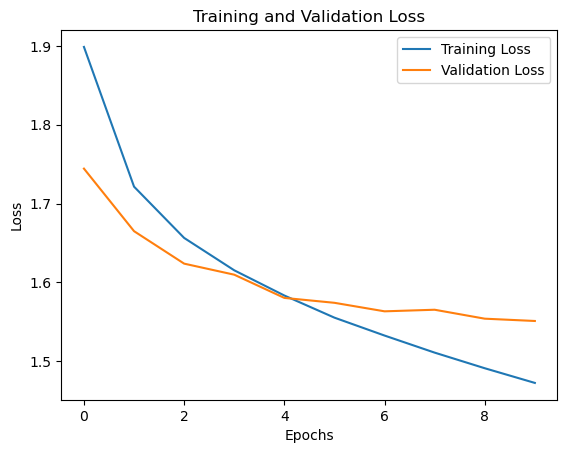

In [387]:
# Testing overfitting on lstm model (rerun lstm model initialisation first)

lstm_model_testing = Sequential()
lstm_model_testing.add(Masking(mask_value=0.0, input_shape=input_shape))
lstm_model_testing.add(Bidirectional(LSTM(lstm_units_1)))
lstm_model_testing.add(Dropout(0.5))
lstm_model_testing.add(Dense(final_unit_size))
lstm_model_testing.add(Dense(word_embedding_size))
lstm_model_testing.compile(optimizer="adam", loss="mse")

lstm_model_testing.summary()

use = int(len(padded_sentences_as_ids) / 50)

# Split the data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    padded_sentences_as_ids[:use], sentences_as_ids_labels[:use], test_size=0.2, random_state=42)

def generate_data(padded_sentences_as_ids, sentences_as_ids_labels, batch_size):
    while True:
        num_samples = len(padded_sentences_as_ids)
        for i in range(0, num_samples, batch_size):
            batch_x = []
            batch_y = []
            for sentence in padded_sentences_as_ids[i:i+batch_size]:
                x_instance = [get_embedding_from_index(idx) for idx in sentence]
                batch_x.append(np.array(x_instance))
            for label in sentences_as_ids_labels[i:i+batch_size]:
                batch_y.append(index_to_embedding[label])
            yield np.array(batch_x), np.array(batch_y)

batch_size = 128
epochs = 10
use_train = len(train_sentences)
use_val = len(val_sentences)

train_generator = generate_data(train_sentences[:use_train], train_labels[:use_train], batch_size)
val_generator = generate_data(val_sentences[:use_val], val_labels[:use_val], batch_size)

history = lstm_model_testing.fit(
    train_generator,
    steps_per_epoch=(use_train // batch_size),
    validation_data=val_generator,
    validation_steps=(use_val // batch_size),
    epochs=epochs
)

# Plot the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4564 - val_loss: 0.8815
Epoch 2/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7976 - val_loss: 0.8261
Epoch 3/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7401 - val_loss: 0.9253
Epoch 4/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9458 - val_loss: 0.7423
Epoch 5/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6573 - val_loss: 0.9435
Epoch 6/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7269 - val_loss: 0.7765
Epoch 7/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5915 - val_loss: 0.7597
Epoch 8/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6802 - val_loss: 0.8333
Epoch 9/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6576 - val_loss: 0.9701
Epoch 10/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6016 - val_loss: 0.7717
Epoch 11/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6397 - val_loss: 0.7573
Epoch 12/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

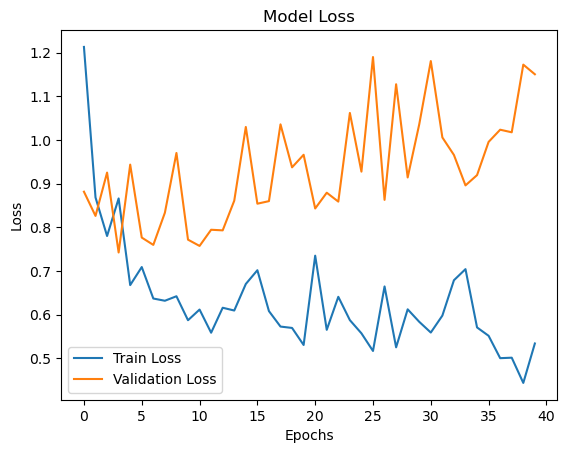

In [404]:
# Testing for overfitting of Siamese model (Rerun Siamese model and training data)

# Split the data into training and validation sets
train_size = int(0.5 * len(claim_seq_array))
claim_train = claim_seq_array[:train_size]
evidence_train = evidence_seq_array[:train_size]
labels_train = labels_seq_array[:train_size]

claim_val = claim_seq_array[train_size:]
evidence_val = evidence_seq_array[train_size:]
labels_val = labels_seq_array[train_size:]

# Fit the model
history = siamese_model.fit(
    [claim_train, evidence_train],
    labels_train,
    validation_data=([claim_val, evidence_val], labels_val),
    epochs=40,
    batch_size=8
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 3.2 FFNN Classification Model

### 3.2.1 Evidence Retrieval
Retrieve the most relevant evidence from the development set and unlabled set

In [363]:
def retrieve_evidences(dataset, k=5, threshold=0.95):
    c_e_pair = {}
    evidences_pairs = {}

    for i, key in enumerate(dataset):

        print(i+1, "/", len(dataset), end='\r')
        claim_index = key
        claim_object = dataset[key]
        claim_text = claim_object['claim_text']
        claim_embedding = torch.from_numpy(run_sentence_through(claim_text))

        unseen_claim_embedding = np.array(run_sentence_through(claim_text))
        nearest_neighbor_indices = lsh_index.get_nns_by_vector(unseen_claim_embedding[0], num_neighbors)

        similarity_scores = {}
        for neighbor_index in nearest_neighbor_indices[:6]:
            similarity_score = cosine_similarity(unseen_claim_embedding, evidence_embeddings[neighbor_index])

            if similarity_score >= threshold:
                similarity_scores[neighbor_index] = similarity_score

        n_most_similar_indices = nlargest(k, similarity_scores, key=similarity_scores.get)
        most_similar_evidences = [filtered_evidence_keys[x] for x in n_most_similar_indices]

        c_e_pair[claim_index] = most_similar_evidences

        evidence_claim_pairs = []
        for index in most_similar_evidences:
            evidence_text = evidence[index]

            # if len(evidence_text) > 1:

            evidence_embedding = torch.from_numpy(run_sentence_through(evidence_text))
            evidence_claim_pair = torch.cat((evidence_embedding, claim_embedding), axis=1)

            evidence_claim_pairs.append(evidence_claim_pair)


        evidences_pairs[claim_index] = evidence_claim_pairs

    return c_e_pair, evidences_pairs

In [364]:
c_e_pair, test_unlabel_evidences_pairs = retrieve_evidences(test_claims_unlabelled)
dev_c_e_pair, dev_evidences_pairs = retrieve_evidences(dev_claims)

### 3.2.2 Label Prediction

Predict labels for unlabeled claims using retrieved evidence

In [368]:
prediction_unlabel = {}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

def index_to_label(index):
    return reverse_label_mapping.get(index, "Unknown")


for index in test_unlabel_evidences_pairs:

    test_object = test_unlabel_evidences_pairs[index]

    pred = cls(test_object)

    prediction_unlabel[index] = {
        'claim_text': test_claims_unlabelled[index]['claim_text'],
        'claim_label': index_to_label(int(torch.argmax(pred))),
        'evidences': c_e_pair[index]
    }

In [396]:
def get_majority(dataset):
    label_counts = Counter()
    for key in dataset:
        claim_object = dataset[key]
        label = claim_object['claim_label']
        label_counts.update([label])
    return label_counts.most_common(1)[0][0]

majority_class = get_majority(train_claims)

Predict labels for development claims using retrieved evidence and ground truth evidence. \
Predict labels using 0-R baseline.

In [397]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

prediction_dev_with_retrieved_es = {}
prediction_dev = {}
prediction_dev_baseline_with_retrieved_es = {}
prediction_dev_baseline = {}

true_labels = [index[1] for index in dev_claim_evidences_pairs]
dev_pred_cls = []
dev_pred_cls_with_retrieved_es = []

dev_pred_baseline = []
dev_pred_baseline_with_retrieved_es = []

# true evidences
for val_index in dev_claim_evidences_pairs:

    val_object = dev_claim_evidences_pairs[val_index]
    val_pred = cls(val_object)
    index = "claim-"+val_index[0]
    
    dev_pred_cls.append(int(torch.argmax(val_pred)))
    dev_pred_baseline.append(label_mapping[majority_class])
    
    
    prediction_dev[index] = {
        'claim_text': dev_claims[index]['claim_text'],
        'claim_label': index_to_label(int(torch.argmax(val_pred))),
        'evidences': dev_c_e_pair[index]
    }
    
    prediction_dev_baseline[index] = {
        'claim_text': dev_claims[index]['claim_text'],
        'claim_label': majority_class,
        'evidences': dev_c_e_pair[index]
    }

# retrieved evidences
for val_index in dev_evidences_pairs:

    val_object = dev_evidences_pairs[val_index]
    val_pred = cls(val_object)

    dev_pred_cls_with_retrieved_es.append(int(torch.argmax(val_pred)))
    dev_pred_baseline_with_retrieved_es.append(label_mapping[majority_class])
    
    
    prediction_dev_with_retrieved_es[index] = {
        'claim_text': dev_claims[val_index]['claim_text'],
        'claim_label': index_to_label(int(torch.argmax(val_pred))),
        'evidences': dev_c_e_pair[index]
    }
    
    prediction_dev_baseline_with_retrieved_es[index] = {
        'claim_text': dev_claims[val_index]['claim_text'],
        'claim_label': majority_class,
        'evidences': dev_c_e_pair[index]
    }

# true evidences
cls_accuracy = accuracy_score(true_labels, dev_pred_cls)
cls_precision = precision_score(true_labels, dev_pred_cls, average='macro')
cls_recall = recall_score(true_labels, dev_pred_cls, average='macro')
cls_f1 = f1_score(true_labels, dev_pred_cls, average='macro')

baseline_accuracy = accuracy_score(true_labels, dev_pred_baseline)
baseline_precision = precision_score(true_labels, dev_pred_baseline, average='macro')
baseline_recall = recall_score(true_labels, dev_pred_baseline, average='macro')
baseline_f1 = f1_score(true_labels, dev_pred_baseline, average='macro')

# retrieved evidences
cls_accuracy_with_retrived_es = accuracy_score(true_labels, dev_pred_cls_with_retrieved_es)
cls_precision_with_retrived_es = precision_score(true_labels, dev_pred_cls_with_retrieved_es, average='macro')
cls_recall_with_retrived_es = recall_score(true_labels, dev_pred_cls_with_retrieved_es, average='macro')
cls_f1_with_retrived_es = f1_score(true_labels, dev_pred_cls_with_retrieved_es, average='macro')

baseline_accuracy_with_retrived_es = accuracy_score(true_labels, dev_pred_baseline_with_retrieved_es)
baseline_precision_with_retrived_es = precision_score(true_labels, dev_pred_baseline_with_retrieved_es, average='macro')
baseline_recall_with_retrived_es = recall_score(true_labels, dev_pred_baseline_with_retrieved_es, average='macro')
baseline_f1_with_retrived_es = f1_score(true_labels, dev_pred_baseline_with_retrieved_es, average='macro')

print("Using True Evidences:")
print(f"Classifier Accuracy: {cls_accuracy:.4f}")
print(f"Classifier Precision: {cls_precision:.4f}")
print(f"Classifier Recall: {cls_recall:.4f}")
print(f"Classifier F1 Score: {cls_f1:.4f}")

print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline Precision: {baseline_precision:.4f}")
print(f"Baseline Recall: {baseline_recall:.4f}")
print(f"Baseline F1 Score: {baseline_f1:.4f}")

print("")
print("Using Retrieved Evidences:")
print(f"Classifier Accuracy: {cls_accuracy_with_retrived_es:.4f}")
print(f"Classifier Precision: {cls_precision_with_retrived_es:.4f}")
print(f"Classifier Recall: {cls_recall_with_retrived_es:.4f}")
print(f"Classifier F1 Score: {cls_f1_with_retrived_es:.4f}")

print(f"Baseline Accuracy: {baseline_accuracy_with_retrived_es:.4f}")
print(f"Baseline Precision: {baseline_precision_with_retrived_es:.4f}")
print(f"Baseline Recall: {baseline_recall_with_retrived_es:.4f}")
print(f"Baseline F1 Score: {baseline_f1_with_retrived_es:.4f}")

Using True Evidences:
Classifier Accuracy: 0.6558
Classifier Precision: 0.3442
Classifier Recall: 0.4706
Classifier F1 Score: 0.3969
Baseline Accuracy: 0.4416
Baseline Precision: 0.1104
Baseline Recall: 0.2500
Baseline F1 Score: 0.1532

Using Retrieved Evidences:
Classifier Accuracy: 0.3506
Classifier Precision: 0.1672
Classifier Recall: 0.2348
Classifier F1 Score: 0.1950
Baseline Accuracy: 0.4416
Baseline Precision: 0.1104
Baseline Recall: 0.2500
Baseline F1 Score: 0.1532


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/anaconda

In [ ]:
# Extract voting layer

label = torch.full((5,), 0,  dtype=torch.float)
print(cls.fc4(cls.dropout2(cls.fc3(label))))

label = torch.full((5,), 1,  dtype=torch.float)
print(cls.fc4(cls.dropout2(cls.fc3(label))))

tensor([-0.3875, -0.5243, -0.5242,  0.6128], grad_fn=<ViewBackward0>)
tensor([-1.5890, -3.0023, -1.8694,  3.1115], grad_fn=<ViewBackward0>)


In [401]:
with open('prediction_unlabel.json', 'w') as f:
    json.dump(prediction_unlabel, f)

with open('prediction_dev.json', 'w') as f:
    json.dump(prediction_dev, f)

Run eval.py CLI

In [402]:
!python3 eval.py --predictions prediction_dev.json --groundtruth data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.005086580086580087
Claim Classification Accuracy (A) = 0.6558441558441559
Harmonic Mean of F and A          = 0.010094866652914794


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*